In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from matplotlib.cm import ScalarMappable
import itertools

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Original CEF estimate function.

# def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
#     model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
#                               n_estimators = n_estimators, 
#                               max_samples= max_samples, 
#                               bootstrap = bootstrap)
#     model.fit(X, y)
#     class_counts = np.zeros((X.shape[0], model.n_classes_))
#     for idx, tree in enumerate(model): # RONAK EDIT
#         # get out of bag indicies
        
#         # RONAK EDIT STARTS HERE ################. Fully out of bag samples.
        
#         #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
#         sampled_indices = model.estimators_samples_[idx]
#         unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
#         # RONAK EDIT ENDS HERE ##################.
        
#         total_unsampled = len(unsampled_indices)
#         np.random.shuffle(unsampled_indices)
#         prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
#         # get all node counts
#         node_counts = tree.tree_.n_node_samples
#         # get probs for eval samples
#         posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
#         for prob_index in prob_indices:
#             posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
#         row_sums = posterior_class_counts.sum(axis=1)
#         row_sums[row_sums == 0] = 1
#         class_probs = (posterior_class_counts/row_sums[:, None])
        
#         where_0 = np.argwhere(class_probs == 0)
#         for elem in where_0:
#             class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
#         where_1 = np.argwhere(class_probs == 1)
#         for elem in where_1:
#             class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
#         class_probs.tolist()
#         partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
#         # get probability for out of bag samples
#         eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
#         eval_class_probs = np.array(eval_class_probs)
#         # find total elements for out of bag samples
#         elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
#         # store counts for each x (repeat fhis for each tree)
#         class_counts[eval_indices] += elems
#     # calculate p(y|X = x) for all x's
#     probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
#     entropies = -np.sum(np.log(probs)*probs, axis = 1)
#     # convert nan to 0
#     entropies = np.nan_to_num(entropies)
#     return np.mean(entropies)

# np.warnings.filterwarnings('ignore')

In [3]:
# The following has a bunch of returns to analyze.
lim = 4
def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap,)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    posteriors = [] #
    
    # Fill the mesh as the function is running.
    x1 = np.arange(-lim, lim+0.05, step=0.025)
    x2 = np.arange(-lim, lim+0.05, step=0.025)
    p = len(x1)
    mesh = np.array(list(itertools.product(x1, x2)))
    def worker(point):
        node = tree.apply(point.reshape(1, -1)).item()
        return posterior[node][0]
    value = np.zeros((len(mesh), 2))
    
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # EDIT STARTS HERE ################. Fully out of bag samples.
        
        # unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
        # EDIT ENDS HERE ##################.
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        posteriors.append(class_probs) #
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
        
        #### Same operation for mesh.
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(mesh)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(mesh)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        value += elems
        ####
        
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    
    avg_posterior = value/value.sum(axis = 1, keepdims = True)
    return np.mean(entropies), posteriors, model, mesh, avg_posterior

np.warnings.filterwarnings('ignore')

In [4]:
def generate_data(n, d = 2, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

def plot_data(X, y, ax, opacity = 1.0, lim = 4):
    sns.set()
    
    palette = sns.color_palette("Dark2")
    colors = [palette[0], palette[2]]
        
    # Data.
    ax.scatter(X[:, 0], X[:, 1], alpha = opacity, s=180, marker='.', c=np.array(colors)[y], edgecolors = 'k')
    ax.set_ylim(-lim, lim)
    ax.set_xlim(-lim, lim)
    ax.set_aspect('equal')

    ax.set_yticks([])
    ax.set_xticks([])

    plt.tight_layout()
    # plt.show()

In [5]:
def get_border(posteriors, ax):
    if posteriors.ndim == 2:
        p = posteriors.shape[0]
        posteriors_p = posteriors.reshape((p,p))
    else:
        p = int(np.sqrt(len(posteriors)))
        posteriors_p = posteriors.reshape((p,p))

    lit_up = np.zeros((p,p))
    current_value_horiz = posteriors_p[0, 0]
    current_value_vert = posteriors_p[0,0]
    for i in range(p):
        for j in range(p):
            if posteriors_p[i, j] != current_value_horiz:
                lit_up[i,j] += 1
                current_value_horiz = posteriors_p[i, j]
#             else:
#                 lit_up[i, j] += 0

            if posteriors_p[j, i] != current_value_vert:
                lit_up[j,i] += 1
                current_value_vert = posteriors_p[j,i]
#             else:
#                 lit_up[j,i] += 0

    lit_up_straight = lit_up.reshape(p**2)

    colors_ = []
    for i in range(p**2):
        if lit_up_straight[i] == 0:
            colors_.append(ax.get_facecolor())
        else:
            colors_.append('black')

    idx = np.array([i for i in range(p**2) if colors_[i] == 'black'])
    not_idx = np.array([i for i in range(p**2) if i not in idx])

    background= len(not_idx)*[ax.get_facecolor()]
    border= len(idx)*['black']
    
    return idx, border

In [6]:
def plot_posterior(tree, posterior, ax, lim = 4):
    x1 = np.arange(-lim, lim+0.05, step=0.025)
    x2 = np.arange(-lim, lim+0.05, step=0.025)
    p = len(x1)
    
    mesh = np.array(list(itertools.product(x1, x2)))
    
    # Figure out which node each point in the mesh falls into, compute its posterior.
    def worker(point):
        node = tree.apply(point.reshape(1, -1)).item()
        return posterior[node][0]
    value = np.array(Parallel(n_jobs=-2)(delayed(worker)(point) for point in mesh))
        
    # Plot value as a color mesh.
    # fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    # Border for where cells change.
    idx, border = get_border(value, ax)
    
    ax.scatter(mesh[idx, 0], mesh[idx, 1], c=border, s=.75)
    ax.scatter(mesh[:, 0], mesh[:, 1], c=value, alpha=0.025, cmap='PRGn')
    # ax.scatter(mesh[:, 0], mesh[:, 1], c=value, alpha=0.8, cmap='PRGn')
    
    ax.set_ylim(-lim, lim)
    ax.set_xlim(-lim, lim)
    ax.set_aspect('equal')

    ax.set_yticks([])
    ax.set_xticks([])
    
    norm = plt.Normalize(0, 1)
    cmap = plt.get_cmap("PRGn")
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Visualize Posterior for One Tree

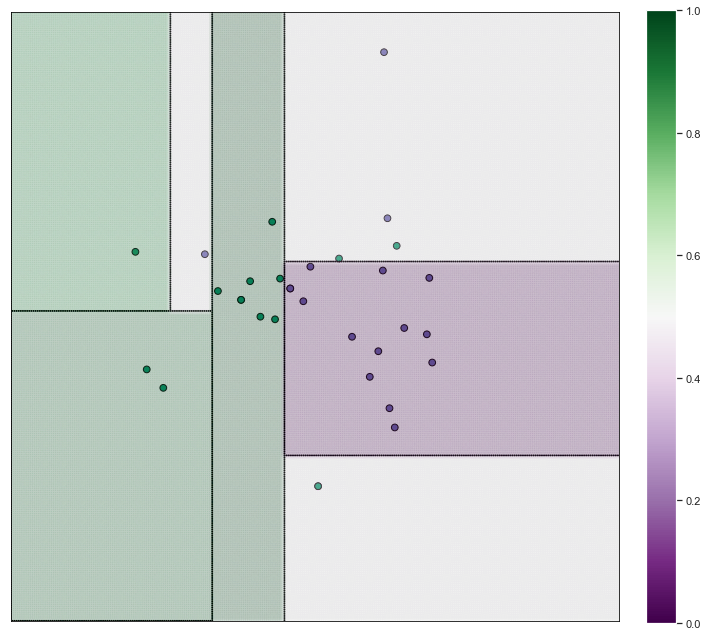

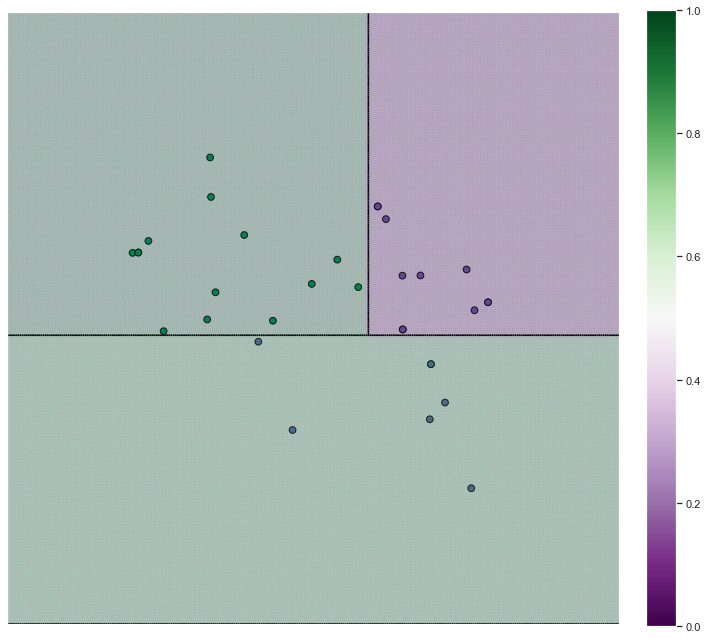

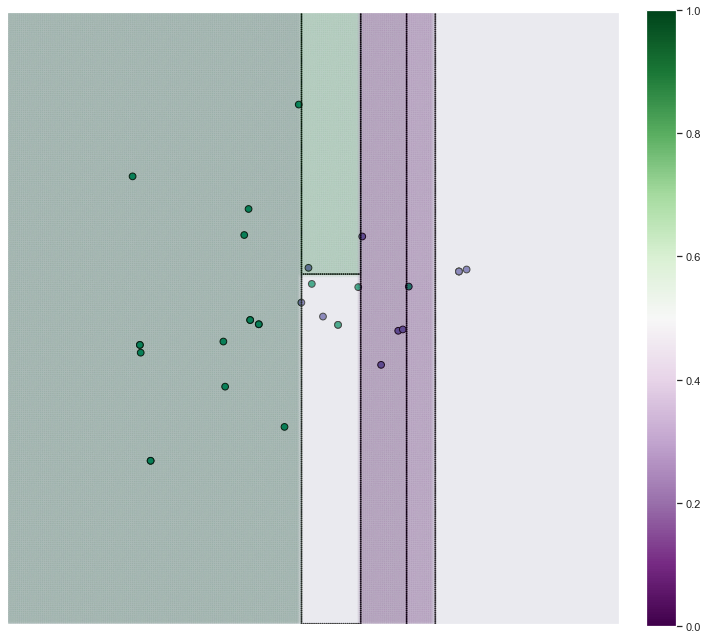

In [7]:
n = 100
X, y = generate_data(n, mu = 1)

n_estimators = 3

cond_entropy, posteriors, model, mesh, avg_posterior = cef_estimate(X, y, n_estimators = n_estimators, depth = 100)

# Do the number of leaves in each posterior match the leaf counts?
for t, tree in enumerate(model):
    sampled_indices = model.estimators_samples_[t]
    unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
    total_unsampled = len(unsampled_indices)
    np.random.shuffle(unsampled_indices)
    prob_indices = unsampled_indices[:total_unsampled//2]
    
    
    # print(posteriors[t])
    
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    plot_data(X[sampled_indices, :], y[sampled_indices], ax)
    plot_posterior(tree, posteriors[t], ax)
    # print(len(posteriors[t]), tree.tree_.node_count)

# Visualize Averager Posterior Across Trees

In [8]:
def plot_avg_posterior(mesh, avg_posterior, ax, lim = 4):

    # Plot value as a color mesh.
    # fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    ax.scatter(mesh[:, 0], mesh[:, 1], c=avg_posterior, alpha=0.025, cmap='PRGn')
    
    ax.set_ylim(-lim, lim)
    ax.set_xlim(-lim, lim)
    ax.set_aspect('equal')

    ax.set_yticks([])
    ax.set_xticks([])
    
    norm = plt.Normalize(0, 1)
    cmap = plt.get_cmap("PRGn")
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

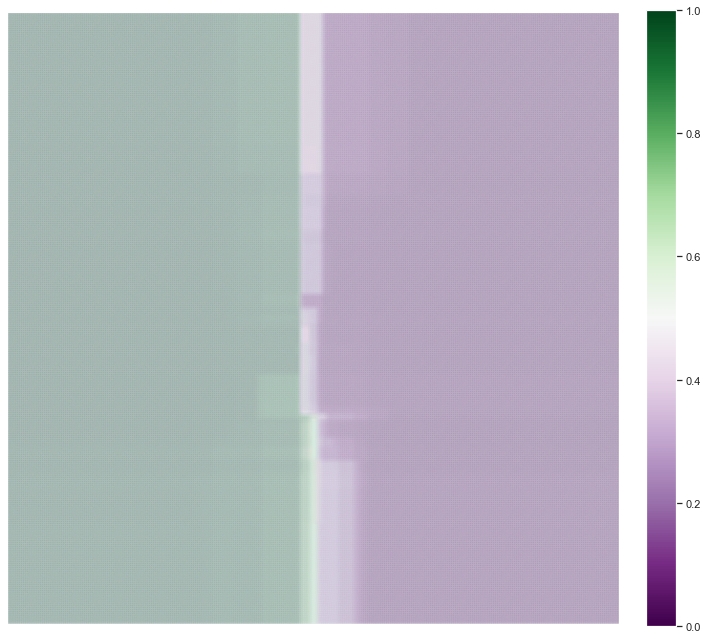

In [9]:
n = 1000
X, y = generate_data(n, mu = 2)

n_estimators = 10

cond_entropy, posteriors, model, mesh, avg_posterior = cef_estimate(X, y, n_estimators = n_estimators)

fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_avg_posterior(mesh, avg_posterior[:, 0], ax)